In [14]:
import pandas as pd
import numpy as np
import sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [16]:
df=pd.read_csv('gurgaon_properties_post_feature_selection_v2.csv')

In [17]:
df.sample(5)

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
3441,flat,sector 37d,1.60,4.0,3.0,3+,Relatively New,2000.0,0.0,0.0,1.0,Medium,Mid Floor
3308,flat,sector 2,1.02,2.0,2.0,3,Moderately Old,1281.0,0.0,0.0,0.0,Medium,High Floor
2794,flat,sector 109,1.68,3.0,3.0,3+,Moderately Old,2303.0,1.0,0.0,0.0,Medium,Mid Floor
3397,flat,sector 2,0.95,2.0,2.0,1,Relatively New,1100.0,0.0,0.0,0.0,Medium,Low Floor
1458,flat,sector 68,1.32,2.0,2.0,2,New Property,1460.0,0.0,0.0,0.0,Low,Mid Floor


In [18]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
1.0    1018
2.0     187
Name: count, dtype: int64

In [19]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [20]:
X = df.drop(columns=['price'])
y = df['price']

In [21]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

In [22]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']


In [23]:
from sklearn.compose import ColumnTransformer

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ],
    remainder='passthrough'
)

In [24]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [25]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [26]:
scores.mean(

)

0.7363096633436828

In [27]:
scores.std()

0.03238005754429938

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)


In [29]:

pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
y_pred = pipeline.predict(X_test)

In [31]:

mean_absolute_error(np.expm1(y_test),y_pred)

1.439366694237234

<Axes: ylabel='Count'>

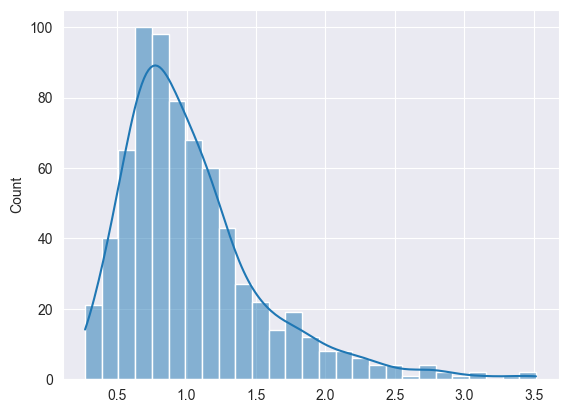

In [32]:
import seaborn as sns
sns.histplot(y_pred,kde=True)

<Axes: ylabel='Count'>

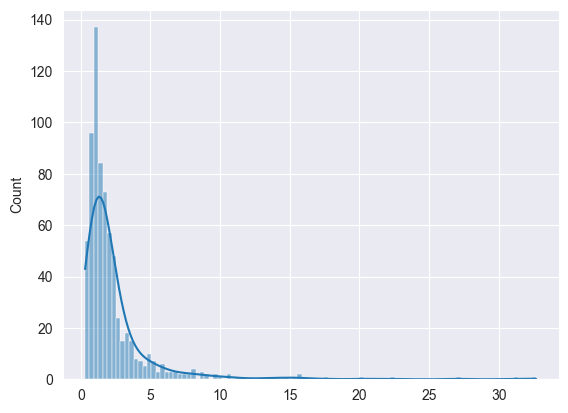

In [33]:
sns.histplot(np.expm1(y_pred),kde=True)

In [34]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso

from xgboost import XGBRegressor



model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [36]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [37]:
model_output

[['linear_reg', 0.7363096633436828, 0.9463822160089355],
 ['svr', 0.7642012011196353, 0.8472636473483927],
 ['ridge', 0.7363125343993552, 0.946338774185337],
 ['LASSO', 0.05943378064493572, 1.528905986892753],
 ['decision tree', 0.769452430111562, 0.7613586521693984],
 ['random forest', 0.8807126300927368, 0.5278013839016682],
 ['extra trees', 0.8679205870138317, 0.55174045413937],
 ['gradient boosting', 0.8725794415893358, 0.575760148829268],
 ['adaboost', 0.7558903112336554, 0.8291278125434889],
 ['mlp', 0.8135445228927687, 0.709762960766208],
 ['xgboost', 0.8894876835260124, 0.5040475141482346]]

In [38]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [39]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.880713,0.527801
6,extra trees,0.867921,0.551740
7,gradient boosting,0.872579,0.575760
9,mlp,0.813545,0.709763
4,decision tree,0.769452,0.761359
8,adaboost,0.755890,0.829128
1,svr,0.764201,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382


In [40]:

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ],
    remainder='passthrough'
)

In [41]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [42]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [65]:
scores.mean(),scores.std()

(0.8546054073648314, 0.01599847663314007)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [67]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [68]:
y_pred = pipeline.predict(X_test)

In [69]:
y_pred = np.expm1(y_pred)

In [70]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6497382874070646

In [71]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [72]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [73]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [74]:
model_output

[['linear_reg', 0.8546054073648314, 0.6497382874070646],
 ['svr', 0.7697413260547326, 0.8341243500492146],
 ['ridge', 0.8546783310939278, 0.65291434945168],
 ['LASSO', 0.05943378064493719, 1.5289059868927557],
 ['decision tree', 0.8061954517334995, 0.6947217680537521],
 ['random forest', 0.8907934370811754, 0.49478949880789147],
 ['extra trees', 0.8939761612377752, 0.4653940714713067],
 ['gradient boosting', 0.8766092969198986, 0.5681835972056221],
 ['adaboost', 0.7535870452077118, 0.8324708816198654],
 ['mlp', 0.8740838749988015, 0.6038529355047088],
 ['xgboost', 0.8958499681743852, 0.4934562667923469]]

In [75]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [76]:
model_df

,name,r2,mae
0,linear_reg,0.854605,0.649738
1,svr,0.769741,0.834124
2,ridge,0.854678,0.652914
3,LASSO,0.059434,1.528906
4,decision tree,0.806195,0.694722
5,random forest,0.890793,0.494789
6,extra trees,0.893976,0.465394
7,gradient boosting,0.876609,0.568184
8,adaboost,0.753587,0.832471
9,mlp,0.874084,0.603853


In [77]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.893976,0.465394
10,xgboost,0.895850,0.493456
5,random forest,0.890793,0.494789
7,gradient boosting,0.876609,0.568184
9,mlp,0.874084,0.603853
0,linear_reg,0.854605,0.649738
2,ridge,0.854678,0.652914
4,decision tree,0.806195,0.694722
8,adaboost,0.753587,0.832471
1,svr,0.769741,0.834124


In [78]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession','furnishing_type'])
    ],
    remainder='passthrough'
)

In [80]:
from sklearn.decomposition import PCA

# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [81]:

# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [82]:
scores.mean(),scores.std()

(0.06225261467032833, 0.019860497587039325)

In [83]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output


In [84]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [85]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [86]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [87]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.759817,0.650987
6,extra trees,0.736254,0.698287
4,decision tree,0.691859,0.761005
10,xgboost,0.621728,0.967351
7,gradient boosting,0.611509,0.987906
1,svr,0.218068,1.361187
8,adaboost,0.304217,1.375086
9,mlp,0.204392,1.430247
2,ridge,0.062253,1.526707
0,linear_reg,0.062253,1.526707


- PCA distorts one-hot encoded features
- Tree-based models or models with interaction terms lose the original signal.
- Keep PCA off for tree-based models

In [88]:
import category_encoders as ce

columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

In [89]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [90]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [91]:
scores.mean(),scores.std()

(0.829521918225536, 0.01838446337912282)

In [92]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [93]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [94]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [95]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [96]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.904798,0.447518
5,random forest,0.901033,0.454810
6,extra trees,0.901004,0.458181
7,gradient boosting,0.888975,0.508624
4,decision tree,0.834998,0.552769
9,mlp,0.854715,0.609470
8,adaboost,0.820539,0.689217
0,linear_reg,0.829522,0.713011
2,ridge,0.829536,0.713523
1,svr,0.782917,0.818851


In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [6]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

NameError: name 'ColumnTransformer' is not defined

In [7]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

NameError: name 'Pipeline' is not defined

In [2]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)



NameError: name 'KFold' is not defined

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ],
    remainder='passthrough'
)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [43]:
pipeline.fit(X,y_transformed)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [45]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [46]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [52]:
X.iloc[0].values


array(['flat', 'sector 36', 3.0, 2.0, '2', 'New Property', 850.0, 0.0,
       0.0, 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [48]:
data = [['house', 'sector 102', 4, 3, '3+', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

In [49]:
one_df = pd.DataFrame(data, columns=columns)

one_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 102,4,3,3+,New Property,2750,0,0,unfurnished,Low,Low Floor


In [50]:
np.expm1(pipeline.predict(one_df))

array([3.59421441])

In [53]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor
